# Linear Approximations to Reaction Networks

## Preliminaries

In [1]:
import control as c
from controlSBML.control_sbml import ControlSBML
import controlSBML.constants as cn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

import os

## Antimony Model

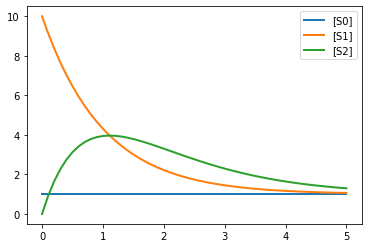

In [13]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
MODEL = """
S0 -> 2 S0; S0
S0 -> S1; S0
S1 -> S2; k2*S1
S2 -> $S3; k3*S2

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""
ROADRUNNER = te.loada(MODEL)
ROADRUNNER.plot(ROADRUNNER.simulate())

In [11]:
ROADRUNNER.reset()
jacobian_mat = ROADRUNNER.getFullJacobian()
jacobian_mat

      S0, S1,  S2
S0 [[  0,  0,   0],
S1  [  1, -1,   0],
S2  [  0,  1, -10]]

In [15]:
CTLSB = ControlSBML(MODEL)

## Accuracy of Linear Model

**TO DO**
1. plot true model and linear approximation for different start times and different non-linearities

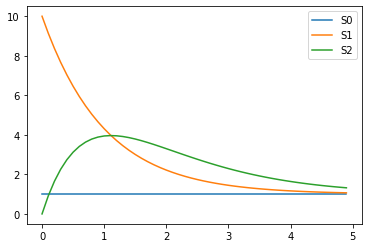

In [16]:
CTLSB.setTime(0)
sys = CTLSB.mkStateSpace()
X0 = CTLSB.mkInitialState()
num_species = len(X0)
times = [0.1*n for n in range(50)]
_, ax = plt.subplots(1)
T, yout = c.forced_response(sys, T=times, X0=X0)
for idx in range(num_species):
    ax.plot(T, yout[idx])
plt.legend(CTLSB.state_names)

# Controllability

In [6]:
B = np.array([1, 0, 0])
B = np.reshape(B, (3, 1))
B

array([[1],
       [0],
       [0]])

In [7]:
sys1 = c.StateSpace(sys.A, B, sys.C, sys.D)
sys1

StateSpace(array([[ -1.,   0.,   0.],
       [  1.,  -1.,   0.],
       [  0.,   1., -10.]]), array([[1.],
       [0.],
       [0.]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[0.],
       [0.],
       [0.]]))

In [8]:
np.linalg.matrix_rank(c.ctrb(sys1.A, sys1.B))

3

In [9]:
np.linalg.eig(sys.A)

(array([-10.,  -1.,  -1.]),
 array([[ 0.00000000e+00,  0.00000000e+00,  2.20686521e-15],
        [ 0.00000000e+00,  9.93883735e-01, -9.93883735e-01],
        [ 1.00000000e+00,  1.10431526e-01, -1.10431526e-01]]))

## Issues
1. Many models wouldn't load in symmathSBML
1. Seems that state includes some elements that are not species, BCK2
1. Why is there a difference between the length of the state_vec and the length of species_names?
1. Need getCurrentState